In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/DataSet/Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title', 'Body'])

In [4]:
df.head()

,Id,Title,Body
0,469,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [5]:
df.shape

(30000, 3)

In [6]:
#Let's take a look at some of the questions
print('Question1: ', df.iloc[0, 2])
print('Question2: ', df.iloc[1, 2])
print('Question3: ', df.iloc[2, 2])

Question1:  <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>

<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>

<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>

<ul>
<li>Some Photoshop javascript</li>
<li>A Python function</li>
<li>An OSX API that I can call from python</li>
</ul>

Question2:  <p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

Question3:  <p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending 

In [7]:
#Using beautiful soup to grab text inside 'p' tags and concatenate it
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')]) #concatenating all p tags
  return question

#Transforming questions to list for ease of processing
question_list = df['Body'].apply(get_question).values.tolist()

In [8]:
question_list[0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of:"

In [9]:
#Tokenizing with simple preprocess gensim's simple preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # returns lowercase tokens, ignoring tokens that are too short or too long

question_words = list(sent_to_words(question_list))

In [10]:
question_words[0][0:5] #first 5 question tokens

['am', 'using', 'the', 'photoshop', 'javascript']

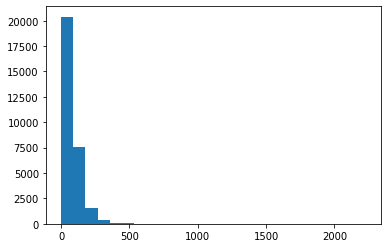

Mean word count of questions is 80.7959


In [11]:
lengths = [len(question) for question in question_words]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [12]:
#Getting rid of stopwords
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
  filtered_words = [word for word in sentence if word not in stop_words]
  return filtered_words

filtered_questions = [remove_stopwords(question) for question in question_words]

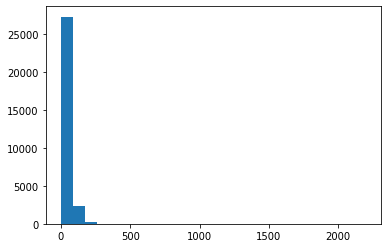

Mean word count of questions is 43.86006666666667


In [13]:
#Examining word counts after removal of stop words

lengths = [len(question) for question in filtered_questions]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [14]:
len(filtered_questions)

30000

Doc2Vec improves on simple averaging method by training a 'document' vector along the word vectors. As in Word2Vec there are two algortihms available to train the model, but I will be using the 'distributed memory' (that's why dm=1 in my model). It trains a model which predicts a word based on its context, by averaging the context word and paragraph ID vectors

In [16]:
n=100
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(filtered_questions)]
model = Doc2Vec(documents, vector_size=n, window=8, min_count=5, workers=2, dm = 1, epochs=20)

In [17]:
print(question_list[42], ' \nis similar to \n')
print([question_list[similar[0]] for similar in model.docvecs.most_similar(42)])

What's the best way to sanitise user input for a Python-based web application? Is there a single function to remove HTML characters and any other necessary characters combinations to prevent an XSS or SQL injection attack?  
is similar to 

['What is the easiest way to strip all html/javascript from a string?', 'I want to use sqlite memory database for all my testing and Postgresql for my development/production server. But the SQL syntax is not same in both dbs. for ex: SQLite has autoincrement, and Postgresql has serial  Is it easy to port the SQL script from sqlite to postgresql... what are your solutions? If you want me to use standard SQL, how should I go about generating primary key in both the databases?', 'and  a.html:', "How do I force Python's print function to output to the screen?", 'I have a script that loops through a series of four (or less) characters strings.  For example: If have been able to implement it with nested for loops like so: Is this sort of loop nesting a ba